In [30]:
from typing import Optional, Any
import warnings
from tifffile import TiffFile, TiffWriter
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
tf.random.set_seed(3)
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import accuracy_score, confusion_matrix, jaccard_score
import itertools
import cv2

In [2]:
def read_stiff(filename: str, silent=False, rgb_only=False):
    """

    :param filename:    filename of the spectral tiff to read.
    :return:            Tuple[spim, wavelengths, rgb, metadata], where
                        spim: spectral image cube of form [height, width, bands],
                        wavelengths: the center wavelengths of the bands,
                        rgb: a color render of the spectral image [height, width, channels] or None
                        metadata: a free-form metadata string stored in the image, or an empty string
    """
    TIFFTAG_WAVELENGTHS = 65000
    TIFFTAG_METADATA = 65111
    spim = None
    wavelengths = None
    rgb = None
    metadata = None

    first_band_page = 0
    with TiffFile(filename) as tiff:
        # The RGB image is optional, the first band image maybe on the first page:
        first_band_page = 0
        if tiff.pages[first_band_page].ndim == 3:
            rgb = tiff.pages[0].asarray()
            # Ok, the first band image is on the second page
            first_band_page = first_band_page + 1

        multiple_wavelength_lists = False
        multiple_metadata_fields = False
        for band_page in range(first_band_page, len(tiff.pages)):
            # The wavelength list is supposed to be on the first band image.
            # The older write_tiff writes it on all pages, though, so make
            # a note of it.
            tag = tiff.pages[band_page].tags.get(TIFFTAG_WAVELENGTHS)
            tag_value = tag.value if tag else tuple()
            if tag_value:
                if wavelengths is None:
                    wavelengths = tag_value
                elif wavelengths == tag_value:
                    multiple_wavelength_lists = True
                elif wavelengths != tag_value:
                    # Well, the image is just broken then?
                    raise RuntimeError(f'Spectral-Tiff "{filename}" contains multiple differing wavelength lists!')

            # The metadata string, like the wavelength list, is supposed to be
            # on the first band image. The older write_tiff wrote it on all
            # pages, too. Make a note of it.
            tag = tiff.pages[band_page].tags.get(TIFFTAG_METADATA)
            tag_value = tag.value if tag else ''
            if tag_value:
                if metadata is None:
                    metadata = tag_value
                elif metadata == tag_value:
                    multiple_metadata_fields = True
                elif metadata != tag_value:
                    # Well, for some reason there are multiple metadata fields
                    # with varying content. This version of the function does
                    # not care for such fancyness.
                    raise RuntimeError(f'Spectral-Tiff "{filename}" contains multiple differing metadata fields!')

        # The metadata is stored in an ASCII string. It may contain back-slashed
        # hex sequences (unicode codepoints presented as ASCII text). Convert
        # ASCII string back to bytes and decode as unicode sequence.
        if metadata:
            metadata = metadata.encode('ascii').decode('unicode-escape')
        else:
            metadata = ''

        # Some of the early images may have errorneus metadata string.
        # Attempt to fix it:
        if len(metadata) >= 2 and metadata[0] == "'" and metadata[-1] == "'":
            while metadata[0] == "'":
                metadata = metadata[1:]
            while metadata[-1] == "'":
                metadata = metadata[:-1]
            if '\\n' in metadata:
                metadata = metadata.replace('\\n', '\n')

        # Generate a fake wavelength list, if the spectral tiff has managed to
        # lose its own wavelength list.
        if not wavelengths:
            wavelengths = range(0, len(tiff.pages) - 1 if rgb is not None else len(tiff.pages))

        if multiple_wavelength_lists and not silent:
            warnings.warn(f'Spectral-Tiff "{filename}" contains duplicated wavelength lists!')
        if multiple_metadata_fields and not silent:
            warnings.warn(f'Spectral-Tiff "{filename}" contains duplicated metadata fields!')

        if not rgb_only:
            spim = tiff.asarray(key=range(first_band_page, len(tiff.pages)))
            spim = np.transpose(spim, (1, 2, 0))
        else:
            spim = None

        # Make sure the wavelengths are in an ascending order:
        if wavelengths[0] > wavelengths[-1]:
            spim = spim[:, :, ::-1] if spim is not None else None
            wavelengths = wavelengths[::-1]

    # Convert uint16 cube back to float32 cube
    if spim is not None and spim.dtype == 'uint16':
        spim = spim.astype('float32') / (2**16 - 1)

    return spim, np.array(wavelengths), rgb, metadata

In [3]:
def read_mtiff(filename):
    """
    Read a mask bitmap tiff.

    Mask bitmap tiff contains multiple pages of bitmap masks. The mask label
    is stored in tag 65001 in each page. The mask label is stored as an ASCII
    string that may contain unicode codepoints encoded as ASCII character
    sequences (see unicode-escape encoding in Python docs).

    :param filename:    filename of the mask tiff to read.
    :return:            Dict[label: str, mask: ndarray], where
                        label: the mask label
                        mask: the boolean bitmap associated with the label.
    """
    TIFFTAG_MASK_LABEL = 65001
    masks = dict()
    with TiffFile(filename) as tiff:
        for p in range(0, len(tiff.pages)):
            label_tag = tiff.pages[p].tags.get(TIFFTAG_MASK_LABEL)
            if label_tag is None:
                if p > 0:
                    print(f'** page {p}: no TIFF_MASK_LABEL tag. Ignored.')
                continue
            label = label_tag.value.encode('ascii').decode('unicode-escape')
            mask = tiff.asarray(key=p)
            masks[label] = mask > 0
    return masks

In [4]:
LABELS = {
            'Specular reflection' : 0,
            'Artery, ICG':          1,
            'Vein':                 2,
            'Stroma, ICG':          3,
            'Blue dye':             4,
            'Red dye':              5,
            'ICG':                  6,
            'Stroma':               7,
            'Umbilical cord':       8,
            'Suture':               9,
            'Artery':               10,
         }

In [5]:
def get_label_code( label_name):
        return LABELS[label_name]

In [6]:
REFLECTANCE_IMAGE_PATH = 'E:/COSI/Semester 3 UEF/IDP/Reflectance spectral images/'
MASK_IMAGE_PATH = 'E:/COSI/Semester 3 UEF/IDP/Set #1 Mask images/'

In [7]:
def create_dataset(image_path,mask_path,classes):
    X = []
    y=[]
    IMAGE_SIZE =128
    image_filenames = listdir(image_path)

    for filename in image_filenames:
        spectra_image, wavelength, rgb, metadata = read_stiff(f"{image_path}/{filename}")  
        image_name = filename.split(".tif")[0]
        mask_image_name = f"{image_name}_masks.tif"
        image_masks_dict = read_mtiff(f"{mask_path}/{mask_image_name}")
        masks  = np.zeros((spectra_image.shape[:2]))
        for label in image_masks_dict:
            spectra_image_mask = image_masks_dict[label].astype(int)
            label_code = get_label_code(label)
            spectra_image_mask[spectra_image_mask == 1] = label_code + 1
            masks = np.maximum(masks,spectra_image_mask)
        y.append(resize(masks,(IMAGE_SIZE,IMAGE_SIZE)))
        X.append(resize(spectra_image,(IMAGE_SIZE,IMAGE_SIZE)))
    
    return X, y

In [8]:
X, y = create_dataset(REFLECTANCE_IMAGE_PATH,MASK_IMAGE_PATH,LABELS)

In [9]:
y = np.array(y).astype(int)
X = np.array(X)
#plt.hist(y.flatten())

In [ ]:
# from sklearn.decomposition import PCA
# def pca(x):
#     imgs = []
#     for x_i in x:
#         x_i = x_i.reshape(x_i.shape[0]*x_i.shape[1], -1)
#         pca = PCA(n_components=3)
#         principalComponents = pca.fit_transform(x_i)
#         img = principalComponents.reshape(IMAGE_SIZE,IMAGE_SIZE,3)
#         imgs.append(img)
#     return np.array(imgs)

In [ ]:
# X = pca(X)

In [ ]:
class_colors = np.array([
            [255,0,0],
            [128,128,128],
            [0,128,0],
            [131,255,51],
            [128,0,128],
            [0,0,255],
            [255,255,0],
            [0,100,100],
            [165,42,42],
            [255,0,255],
            [255,165,0],[0,0,0]])
#reshaped_classes = np.array(classes).reshape(-1,1) 

In [10]:
labelEncoder = LabelEncoder()
n, h, w = y.shape
y_reshaped = y.reshape(-1)
y_reshaped_encoded = labelEncoder.fit_transform(y_reshaped)
y_encoded = y_reshaped_encoded.reshape(n,h,w)

In [11]:
y_expanded = np.expand_dims(y,axis=3)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,shuffle= True, random_state=42)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test,len(LABELS))

In [12]:
class_weights = class_weight.compute_class_weight("balanced",np.unique(y_reshaped),y_reshaped)
class_weights = {l:c for l,c in zip(np.unique(y_reshaped), class_weights)}
sample_weights = class_weight.compute_sample_weight(class_weights,y_train.reshape(-1,1))
y_n, y_h, y_w = y_train.shape
sample_weights = sample_weights.reshape(y_n,y_h,y_w)

D:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [13]:
IMAGE_SIZE =128
IMAGE_CHANNELS = 38
def convo_block(input_shape, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input_shape)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input_shape, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_shape)
    x = Dropout(0.1)(x)
    x = Concatenate()([x, skip_features])
    x = convo_block(x, num_filters)
    return x

def build_resnet50_unet(n_classes):
    """ Input """
    input_shape = (IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS)
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights=None ,input_tensor=inputs) #, input_tensor=inputs
    
    #resnet50.summary()
#     print(resnet50.get_layer(0).output) 

    """ Encoder """
    s1 = resnet50.layers[0].output                      ##get output from input layer  128 x 128
    s2 = resnet50.get_layer("conv1_relu").output        ## 64x64
    s3 = resnet50.get_layer("conv2_block3_out").output  ## 32x32
    s4 = resnet50.get_layer("conv3_block4_out").output  ## 16x16
    
#     print(s1,s2,s3,s4)
    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## 8x8

    """ Decoder """
    d1 = decoder_block(b1, s4, 128)                     ## 16x16
    d2 = decoder_block(d1, s3, 64)                     ## 32x32
    d3 = decoder_block(d2, s2, 32)                     ## 64x64
    d4 = decoder_block(d3, s1, 16)                     ##128x128
 

#     """ Output """
    outputs = Conv2D(n_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

In [14]:
n_classes = len(LABELS)
model = build_resnet50_unet(n_classes)
model.compile(optimizer="adam", loss="categorical_crossentropy" ,metrics="accuracy",sample_weight_mode="temporal")
model.summary()

Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 38 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 38) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   119232      conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
_____________________________________________________________________________________

In [15]:
batch_size = 32
epochs = 300

In [16]:
history = model.fit(X_train,y_train_cat,batch_size=batch_size,epochs=epochs)

Epoch 1/300
1/1 [==============================] - 17s 17s/step - loss: 2.7128 - accuracy: 0.0581
Epoch 2/300
1/1 [==============================] - 0s 426ms/step - loss: 2.5712 - accuracy: 0.0708
Epoch 3/300
1/1 [==============================] - 0s 417ms/step - loss: 2.4911 - accuracy: 0.0811
Epoch 4/300
1/1 [==============================] - 0s 391ms/step - loss: 2.4379 - accuracy: 0.0941
Epoch 5/300
1/1 [==============================] - 0s 404ms/step - loss: 2.3999 - accuracy: 0.1093
Epoch 6/300
1/1 [==============================] - 0s 401ms/step - loss: 2.3714 - accuracy: 0.1254
Epoch 7/300
1/1 [==============================] - 0s 397ms/step - loss: 2.3465 - accuracy: 0.1402
Epoch 8/300
1/1 [==============================] - 0s 402ms/step - loss: 2.3242 - accuracy: 0.1571
Epoch 9/300
1/1 [==============================] - 0s 384ms/step - loss: 2.3026 - accuracy: 0.1695
Epoch 10/300
1/1 [==============================] - 0s 396ms/step - loss: 2.2800 - accuracy: 0.1822
Epoch 11/3

1/1 [==============================] - 0s 399ms/step - loss: 1.2881 - accuracy: 0.6300
Epoch 84/300
1/1 [==============================] - 0s 400ms/step - loss: 1.2768 - accuracy: 0.6349
Epoch 85/300
1/1 [==============================] - 0s 391ms/step - loss: 1.2707 - accuracy: 0.6336
Epoch 86/300
1/1 [==============================] - 0s 391ms/step - loss: 1.2612 - accuracy: 0.6405
Epoch 87/300
1/1 [==============================] - 0s 391ms/step - loss: 1.2516 - accuracy: 0.6475
Epoch 88/300
1/1 [==============================] - 0s 387ms/step - loss: 1.2424 - accuracy: 0.6481
Epoch 89/300
1/1 [==============================] - 0s 393ms/step - loss: 1.2339 - accuracy: 0.6534
Epoch 90/300
1/1 [==============================] - 0s 396ms/step - loss: 1.2249 - accuracy: 0.6575
Epoch 91/300
1/1 [==============================] - 0s 405ms/step - loss: 1.2149 - accuracy: 0.6635
Epoch 92/300
1/1 [==============================] - 0s 396ms/step - loss: 1.2085 - accuracy: 0.6693
Epoch 93/300


1/1 [==============================] - 0s 399ms/step - loss: 0.7875 - accuracy: 0.8158
Epoch 165/300
1/1 [==============================] - 0s 401ms/step - loss: 0.7833 - accuracy: 0.8187
Epoch 166/300
1/1 [==============================] - 0s 406ms/step - loss: 0.7820 - accuracy: 0.8165
Epoch 167/300
1/1 [==============================] - 0s 397ms/step - loss: 0.7789 - accuracy: 0.8172
Epoch 168/300
1/1 [==============================] - 0s 402ms/step - loss: 0.7728 - accuracy: 0.8194
Epoch 169/300
1/1 [==============================] - 0s 399ms/step - loss: 0.7708 - accuracy: 0.8186
Epoch 170/300
1/1 [==============================] - 0s 404ms/step - loss: 0.7644 - accuracy: 0.8221
Epoch 171/300
1/1 [==============================] - 0s 405ms/step - loss: 0.7619 - accuracy: 0.8216
Epoch 172/300
1/1 [==============================] - 0s 407ms/step - loss: 0.7571 - accuracy: 0.8233
Epoch 173/300
1/1 [==============================] - 0s 400ms/step - loss: 0.7527 - accuracy: 0.8252
Epoc

1/1 [==============================] - 0s 397ms/step - loss: 0.5700 - accuracy: 0.8564
Epoch 246/300
1/1 [==============================] - 0s 397ms/step - loss: 0.5662 - accuracy: 0.8570
Epoch 247/300
1/1 [==============================] - 0s 399ms/step - loss: 0.5666 - accuracy: 0.8563
Epoch 248/300
1/1 [==============================] - 0s 390ms/step - loss: 0.5657 - accuracy: 0.8559
Epoch 249/300
1/1 [==============================] - 0s 393ms/step - loss: 0.5650 - accuracy: 0.8567
Epoch 250/300
1/1 [==============================] - 0s 403ms/step - loss: 0.5613 - accuracy: 0.8572
Epoch 251/300
1/1 [==============================] - 0s 397ms/step - loss: 0.5605 - accuracy: 0.8574
Epoch 252/300
1/1 [==============================] - 0s 397ms/step - loss: 0.5592 - accuracy: 0.8576
Epoch 253/300
1/1 [==============================] - 0s 393ms/step - loss: 0.5575 - accuracy: 0.8578
Epoch 254/300
1/1 [==============================] - 0s 390ms/step - loss: 0.5548 - accuracy: 0.8584
Epoc

In [ ]:
# model.save_weights('ResUnet_weights.h5')

In [ ]:
# model.save('ResUnet_model_b_32_ep_300.h5')

In [17]:
filename = "upper_10_icg.tif"

In [27]:
def get_predicted_mask(filename,class_colors):
    spim, wavelength, rgb_img, metadata = read_stiff(f"{REFLECTANCE_IMAGE_PATH}/{filename}")
    test_image = resize(spim,(IMAGE_SIZE,IMAGE_SIZE)) # spim for spectral image
    test_image = np.expand_dims(test_image, axis=0)


# get mask
    image_name = filename.split(".tif")[0]
    filemask = f"{image_name}_masks.tif"
    image_masks_dict = read_mtiff(f"{MASK_IMAGE_PATH}/{filemask}")
    masks = np.zeros((spim.shape[:2]))
    for label in image_masks_dict:
        spectra_image_mask = image_masks_dict[label].astype(int)
        label_code = get_label_code(label)
        spectra_image_mask[spectra_image_mask == 1] = label_code + 1
        masks = np.maximum(masks,spectra_image_mask)
    masks = resize(masks,(IMAGE_SIZE,IMAGE_SIZE))

    gt_mask = masks 
    gt_mask = np.expand_dims(masks, axis=-1)
    combined_gtmask = np.zeros((test_image.shape[1:3]))
    combined_gtmask = np.stack((combined_gtmask,)*3, axis=-1)


    pred_mask = model.predict(test_image)

    pred_mask = np.expand_dims(np.squeeze(np.argmax(pred_mask, axis=3)),axis=-1)
    combined_predmask = np.zeros((test_image.shape[1:3]))
    combined_predmask = np.stack((combined_predmask,)*3, axis=-1)
    
    xy_list_gt = np.where(gt_mask!=0)
    x_list_gt = xy_list_gt[0]
    y_list_gt = xy_list_gt[1]

    for x, y in zip(x_list_gt, y_list_gt):
        idx = gt_mask[x,y,0].astype(int)
        combined_gtmask[x,y,:] = class_colors[idx]
        
    xy_list_pred_mask = np.where(pred_mask!=0)
    x_list_pred_mask = xy_list_pred_mask[0]
    y_list_pred_mask = xy_list_pred_mask[1]

    for x, y in zip(x_list_pred_mask, y_list_pred_mask):
        idxpred = pred_mask[x,y,0]
        combined_predmask[x,y,:] = class_colors[idxpred]
    
    return rgb_img,combined_gtmask, combined_predmask



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicted truth mask')

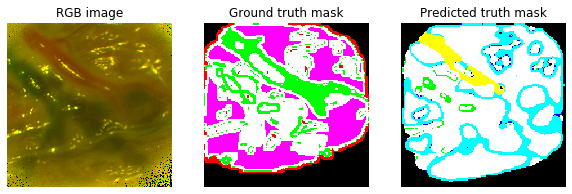

In [29]:
class_colors = np.array([
            [255,0,0],
            [128,128,128],
            [0,128,0],
            [131,255,51],
            [128,0,128],
            [0,0,255],
            [255,255,0],
            [0,100,100],
            [165,42,42],
            [255,0,255],
            [255,165,0],[0,0,0]])

rgb_image, gt_mask,pred_mask = get_predicted_mask(filename,class_colors)
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 3, 1)

plt.imshow(rgb_image)
plt.axis('off')
plt.title("RGB image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(1, 3, 2)
  
# showing image
plt.imshow(gt_mask)
plt.axis('off')
plt.title("Ground truth mask")
  
# Adds a subplot at the 3rd position
fig.add_subplot(1, 3, 3)
  
# showing image
plt.imshow(pred_mask)
plt.axis('off')
plt.title("Predicted truth mask")